In [13]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, get_body
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import time

import pandas as pd

from astropy.visualization import quantity_support
quantity_support()

import sys
sys.path.append("../lsst_detection_probability/")

from variant_orbits import variant_orbit_ephemerides

In [2]:
plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

%config InlineBackend.figure_format = 'retina'

plt.style.use("dark_background")

In [17]:
def add_stars(ax, starsurfacedensity=0.8, lw=1):
    starcolor = (1.,1.,1.)
    area = np.sqrt(np.sum(np.square(ax.transAxes.transform([1.,1.]) - ax.transAxes.transform([0.,0.]))))*1
    nstars = int(starsurfacedensity*area)

    #small stars
    xy = np.random.uniform(size=(nstars,2))
    ax.scatter(xy[:,0],xy[:,1], transform=ax.transAxes, alpha=0.05, s=8*lw, facecolor=starcolor, edgecolor=None, zorder=3, rasterized=True)
    ax.scatter(xy[:,0],xy[:,1], transform=ax.transAxes, alpha=0.1, s=4*lw, facecolor=starcolor, edgecolor=None, zorder=3, rasterized=True)
    ax.scatter(xy[:,0],xy[:,1], transform=ax.transAxes, alpha=0.2, s=0.5*lw, facecolor=starcolor, edgecolor=None, zorder=3, rasterized=True)

    #large stars
    xy = np.random.uniform(size=(nstars//4,2))
    ax.scatter(xy[:,0],xy[:,1], transform=ax.transAxes, alpha=0.1, s=15*lw, facecolor=starcolor, edgecolor=None, zorder=3, rasterized=True)
    ax.scatter(xy[:,0],xy[:,1], transform=ax.transAxes, alpha=0.1, s=5*lw, facecolor=starcolor, edgecolor=None, zorder=3, rasterized=True)
    ax.scatter(xy[:,0],xy[:,1], transform=ax.transAxes, alpha=0.5, s=2*lw, facecolor=starcolor, edgecolor=None, zorder=3, rasterized=True)

In [18]:
def get_pointer_pos(pointing, earth_position, distance):
    m = (pointing.y - earth_position.y) / (pointing.x - earth_position.x)
    c = pointing.y - m * pointing.x
    
    pointer_x = earth_position.x - distance / (m**2 + 1)**(0.5)
    pointer_y = pointer_x * m + c
    
    return pointer_x, pointer_y

# Get obs

In [7]:
obs = pd.read_hdf("../neocp/neo/filtered_visit_000.h5").set_index("hex_id")

In [8]:
obs.index.unique()

Index(['0000025', '0000027', '0000028', '000002B', '000002C', '0000031',
       '000000B', '000000D', '000000F', '0000010',
       ...
       '003DAE2', '003EB1D', '003EF80', '003E796', '003F7D0', '003FEA3',
       '003FEFF', '003FF23', '0040D2E', '00401A0'],
      dtype='object', name='hex_id', length=1365)

In [9]:
rows = obs.loc["003EB1D"]
distances = np.logspace(-1, 1, 15) * u.AU
radial_velocities = np.linspace(-50, 10, 6) * u.km / u.s
D, RV = np.meshgrid(distances, radial_velocities)
eph_times = Time(rows.iloc[0]["FieldMJD"] + np.linspace(-200, 400, 600), format="mjd")

In [10]:
earth_position = get_body("earth", Time(rows.iloc[0]["FieldMJD"], format="mjd"))\
    .transform_to("heliocentriceclipticiau76")\
    .represent_as("cartesian")
pointing = SkyCoord(ra=rows.iloc[0]["AstRA(deg)"] * u.deg,
                    dec=rows.iloc[0]["AstDec(deg)"] * u.deg,
                    distance=1000*u.AU, frame="icrs")\
    .transform_to("heliocentriceclipticiau76").represent_as("cartesian")

In [11]:
ephemerides = variant_orbit_ephemerides(ra=rows.iloc[0]["AstRA(deg)"] * u.deg,
                                        dec=rows.iloc[0]["AstDec(deg)"] * u.deg,
                                        ra_end=rows.iloc[-1]["AstRA(deg)"] * u.deg,
                                        dec_end=rows.iloc[-1]["AstDec(deg)"] * u.deg,
                                        delta_t=(rows.iloc[-1]["FieldMJD"] - rows.iloc[0]["FieldMJD"]) * u.day,
                                        obstime=Time(rows.iloc[0]["FieldMJD"], format="mjd"),
                                        distances=distances,
                                        radial_velocities=radial_velocities,
                                        eph_times=eph_times,
                                        only_neos=True)
ephemerides["orbit_id"] = ephemerides["orbit_id"].astype(int)

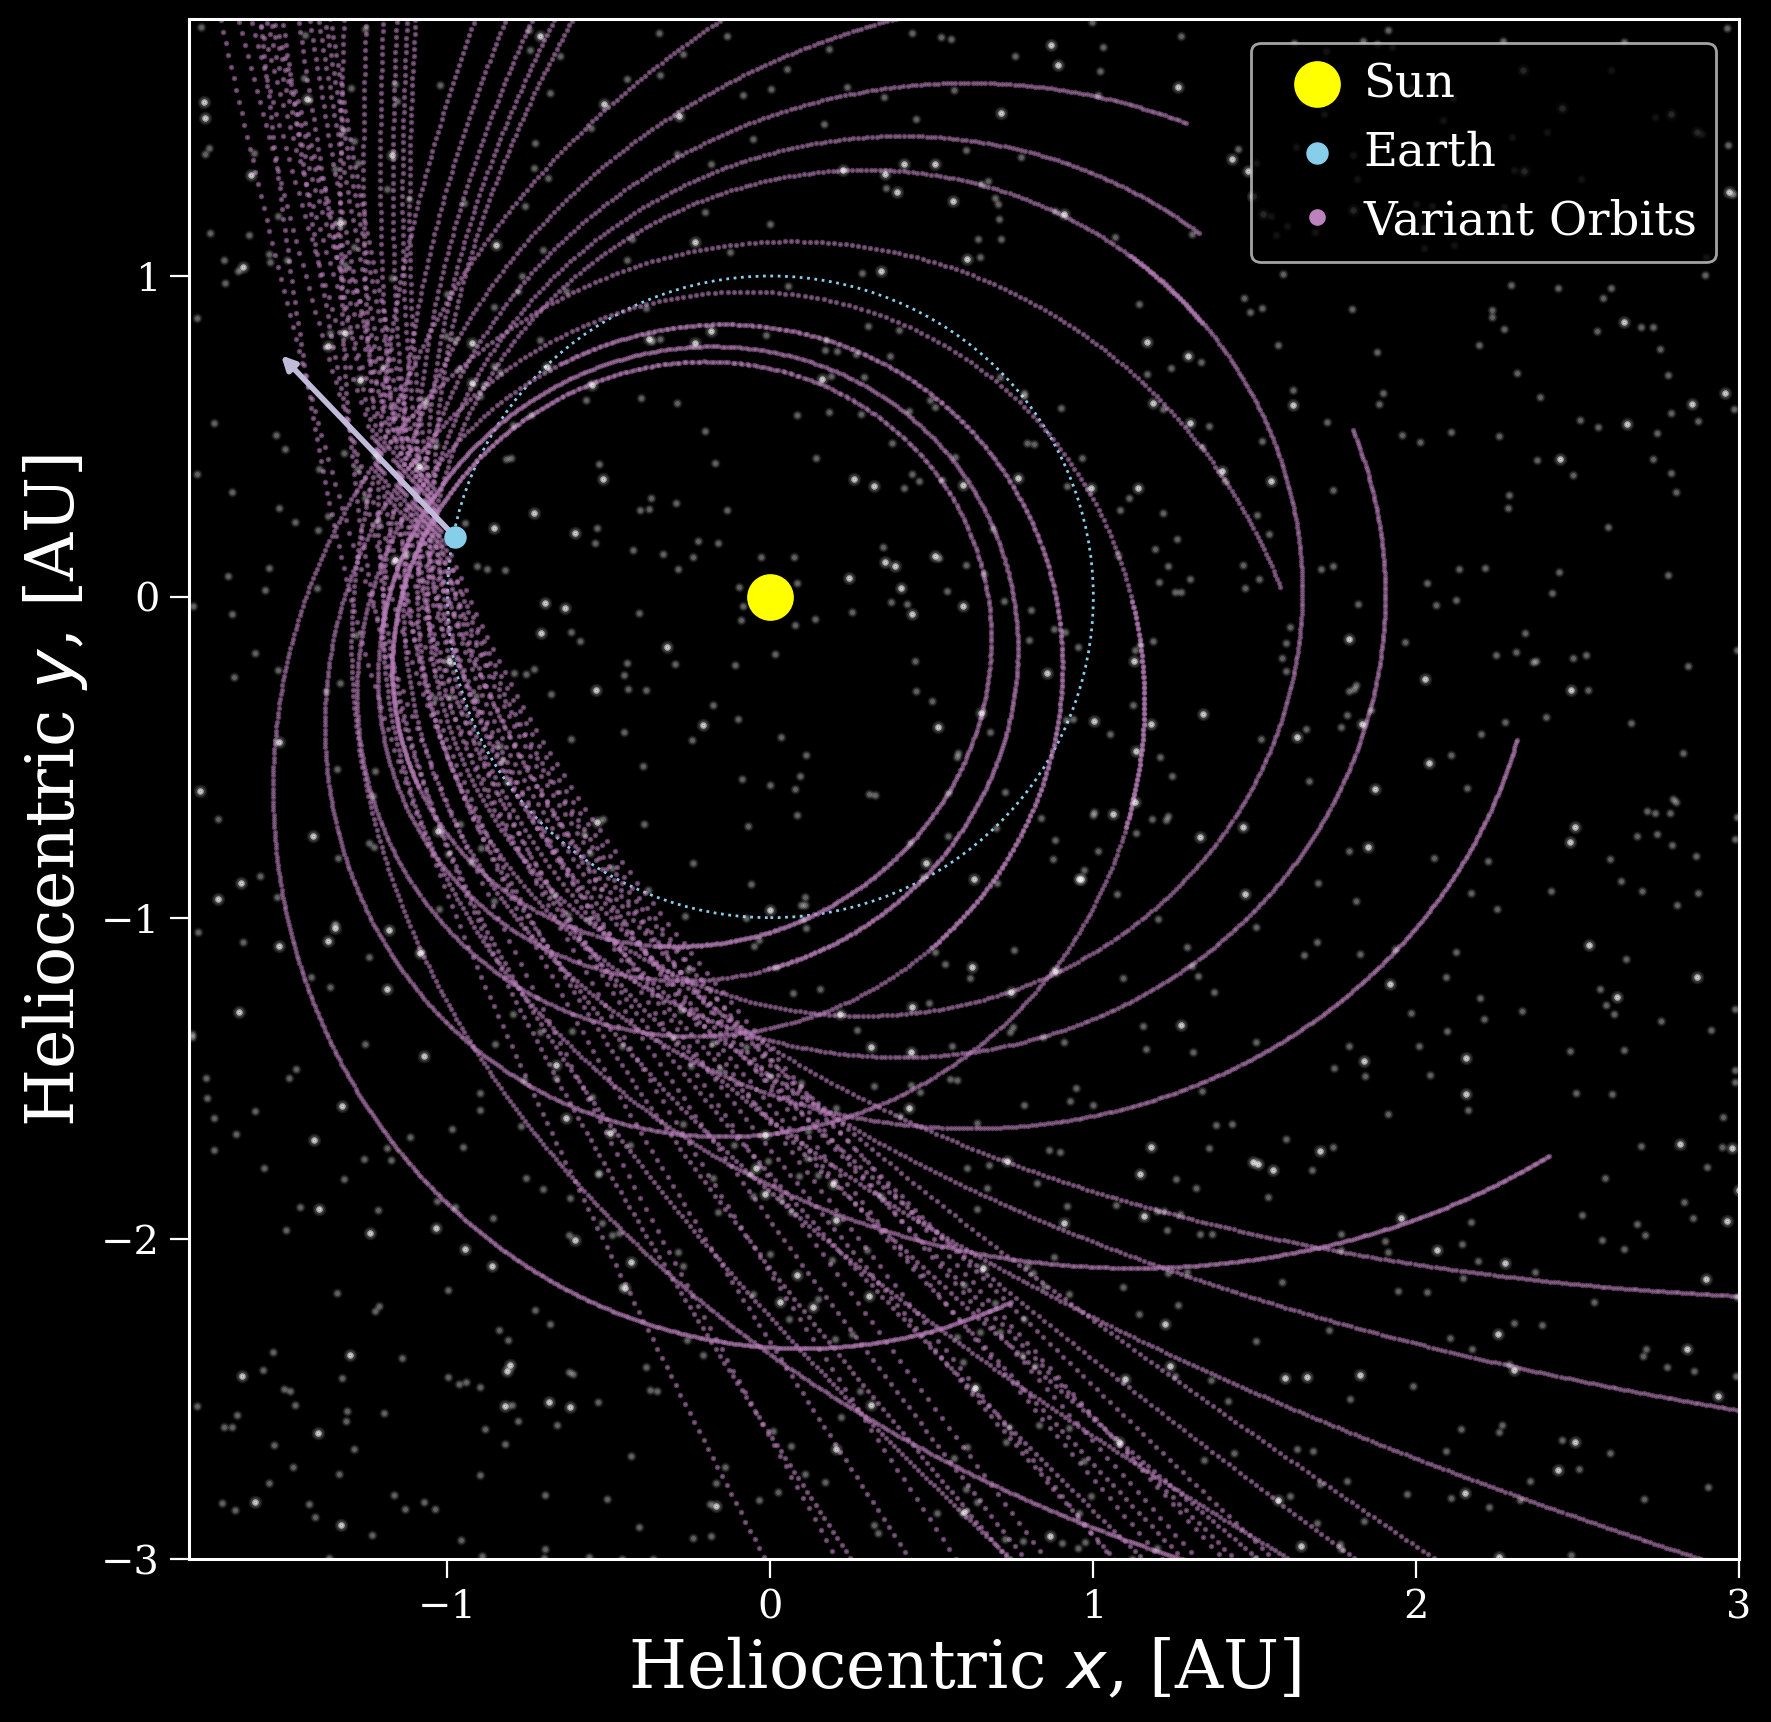

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter([0], [0], color="yellow", zorder=10, s=250, label="Sun")

ax.scatter(earth_position.x, earth_position.y, color="skyblue", zorder=10,
           label="Earth", s=50)

earth = plt.Circle((0, 0), radius=1, facecolor="none",
                   edgecolor="skyblue", linestyle="dotted")
ax.add_artist(earth)

pointer_pos = get_pointer_pos(pointing, earth_position, 0.8 * u.AU)

ax.annotate("", xy=(earth_position.x.value, earth_position.y.value),
            xytext=pointer_pos, arrowprops=dict(arrowstyle="<|-", color="C2", lw=2),
            ha="center", va="center")

ax.scatter(ephemerides["obj_x"], ephemerides["obj_y"], s=1,
           label="Variant Orbits", color="C7", alpha=0.45, zorder=2, rasterized=True)
secret_circle = Line2D([0], [0], marker='o', color='none', label='Scatter',
                       markerfacecolor='C7', markersize=7)

add_stars(ax)

# lims = 2.5
# ax.set_xlim(-lims, lims)
# ax.set_ylim(-lims, lims)

ax.set_xlim(-1.8, 3)
ax.set_ylim(-3, 1.8)

handles, labels = ax.get_legend_handles_labels()
handles[-1] = secret_circle

ax.legend(handles=handles, labels=labels, loc="upper right",
          markerscale=1, handletextpad=0, fontsize=0.7*fs)

ax.set_xlabel(r"Heliocentric $x$, [AU]")
ax.set_ylabel(r"Heliocentric $y$, [AU]")

plt.savefig("../paper/figures/orbits_example_small.pdf", format="pdf", bbox_inches="tight", dpi=300)

plt.show()